# TME5 policy gradients - A2C

In [1]:
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
from utils_rdl import smooth

import numpy as np
from random import sample, random
from tqdm import tqdm
from collections import deque

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

from utils_rdl import NN, AleaStock, play_one_run

matplotlib.use("TkAgg")
import gym
import gridworld
from gym import wrappers, logger

from utils_rdl import NN
from utils_rdl import play_one_run, train_agent
from utils_rdl import GridWorldMethods, GridWorldFeaturesMethods, CartPoleDiscreteMethods, LunarLanderDiscreteMethods
from utils_rdl import MountainCarContinuousMethods, PendulumContinuousMethods, LunarLanderContinuousMethods
from utils_rdl import BaseAgent, BaseMemAgent, BaseBatchEpisodeAgent


Using matplotlib backend: Qt5Agg


## Agents

In [27]:
class BaseA2CAgent(BaseAgent):
    def __init__(self, action_space, obs0, layers_V, layers_pi, lr_pi, lr_V, gamma=0.99, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gamma     = gamma
        self.action_space = action_space

        inSize = self.Phi(obs0).shape[-1]
        outSize = action_space.n
        self.V  = NN(inSize, 1,       layers_V)
        self.pi = NN(inSize, outSize, layers_pi)
        self.optimizer_V  = torch.optim.Adam(params=self.V.parameters(), lr=lr_V)
        self.optimizer_pi = torch.optim.SGD(params=self.pi.parameters(), lr=lr_pi)
        self.loss_fun_V = nn.SmoothL1Loss(reduction='sum')

        self.step = 0
        self.log_dict['loss_V'] = []
        self.log_dict['loss_pi'] = []

    def act(self, s2):
        with torch.no_grad():
            self.pi.eval()
            s2_t = torch.from_numpy(s2)
            a1 = torch.multinomial(torch.softmax(self.pi(s2_t), dim=-1), num_samples=1).item()
        return a1

    def compute_target_V(self, r, s2):
        raise NotImplementedError
        
    def update(self, batch):
        s1, a, r, s2, d = batch
        target_V = self.compute_target_V(r, s2, d)
        self.optimizer_V.zero_grad()
        self.V.train()
        loss_V = self.loss_fun_V(self.V(s1), target_V.view(-1,1))
        loss_V.backward()
        self.optimizer_V.step()

        with torch.no_grad():
#             A = r.view(-1,1).float() + self.gamma*self.V(s2)*(~d).float() - self.V(s1)
            A = target_V - self.V(s1)
        self.optimizer_pi.zero_grad()
        self.pi.train()
        loss_pi = torch.gather(torch.log_softmax(self.pi(s1), dim=-1), 1, a.view(-1,1)) * A
        loss_pi = - torch.sum(loss_pi)
        loss_pi.backward()
        self.optimizer_pi.step()

        self.log_dict['loss_V' ].append((self.step, loss_V .item()))
        self.log_dict['loss_pi'].append((self.step, loss_pi.item()))
        self.step += 1
        
#         if self.writer is not None:# and self.step%self.C in (0,1):
#             self.writer.add_scalar('loss_pi', loss_pi, self.step)
#             self.writer.add_scalar('loss_V',  loss_V,  self.step)
#             for i,fn in enumerate(self.Q.layers):
#                 self.writer.add_histogram('param difference/layer{}'.format(i), fn.weight-fnhat.weight, self.step)
#                 self.writer.add_histogram('weights/layer{}'.format(i), fn.weight, self.step)
#                 self.writer.add_histogram('grad/layer{}'.format(i), fn.weight.grad, self.step)
#     def observe(self, state1, action, reward, state2, done):
#         raise NotImplementedError
            
            
class OnlineA2CAgent(BaseA2CAgent):
    def compute_target_V(self, r, s2, d):
        with torch.no_grad():
            target_V = r + self.gamma * self.V(s2) * (~d).float()
        return target_V
    def observe(self, s1, a, r, s2, done):
        s1_t = torch.tensor(s1).view(1,-1)
        s2_t = torch.tensor(s2).view(1,-1)
        a_t = torch.tensor(a).view(1,1)
        r_t = torch.tensor(r).view(1,1).float()
        d_t = torch.tensor(done).view(1,1)
        batch = (s1_t, a_t, r_t, s2_t, d_t)
        self.update(batch)
            
            
class BatchA2CAgent(BaseA2CAgent, BaseBatchEpisodeAgent):
    def compute_target_V(self, r, s2, d):
        with torch.no_grad():
            target_V = torch.zeros(len(r), dtype=s2.dtype)
            target_V[-1] = r[-1]
            for i in range(len(r)-1, 0, -1):
                target_V[i-1] = target_V[i] + r[i-1]
        return target_V


## Cartpole

In [28]:
env_methods = CartPoleDiscreteMethods()
env = gym.make(env_methods.get_env_name())
# env = gym.make('CartPole-v1')


env_name = 'CartPole-v1'


In [37]:
## Online
gamma = .999

layers_pi = [10, 10, 10]
layers_V  = [10, 10, 10]
lr_pi = 1e-3
lr_V  = 1e-3

obs0 = env.reset()
agent = OnlineA2CAgent(env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi, lr_V=lr_V,
    gamma=gamma,
    env_methods=env_methods,
    )




out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=1500)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=33	DONE    	rsum=33.0
Episode 2	num_iter=27	DONE    	rsum=27.0
Episode 3	num_iter=9	DONE    	rsum=9.0
Episode 4	num_iter=31	DONE    	rsum=31.0
Episode 5	num_iter=19	DONE    	rsum=19.0
Episode 6	num_iter=28	DONE    	rsum=28.0
Episode 7	num_iter=11	DONE    	rsum=11.0
Episode 8	num_iter=12	DONE    	rsum=12.0
Episode 9	num_iter=10	DONE    	rsum=10.0
Episode 10	num_iter=21	DONE    	rsum=21.0
Episode 11	num_iter=48	DONE    	rsum=48.0
Episode 12	num_iter=21	DONE    	rsum=21.0
Episode 13	num_iter=36	DONE    	rsum=36.0
Episode 14	num_iter=27	DONE    	rsum=27.0
Episode 15	num_iter=14	DONE    	rsum=14.0
Episode 16	num_iter=64	DONE    	rsum=64.0
Episode 17	num_iter=14	DONE    	rsum=14.0
Episode 18	num_iter=24	DONE    	rsum=24.0
Episode 19	num_iter=22	DONE    	rsum=22.0
Episode 20	num_iter=13	DONE    	rsum=13.0
Episode 21	num_iter=17	DONE    	rsum=17.0
Episode 22	num_iter=17	DONE    	rsum=17.0
Episode 23	num_iter=22	DONE    	rsum=22.0
Episode 24	num_iter=20	DONE    	rsum=20.0
Epi

Episode 199	num_iter=10	DONE    	rsum=10.0
Episode 200	num_iter=9	DONE    	rsum=9.0
Episode 201	num_iter=9	DONE    	rsum=9.0
Episode 202	num_iter=8	DONE    	rsum=8.0
Episode 203	num_iter=9	DONE    	rsum=9.0
Episode 204	num_iter=10	DONE    	rsum=10.0
Episode 205	num_iter=10	DONE    	rsum=10.0
Episode 206	num_iter=10	DONE    	rsum=10.0
Episode 207	num_iter=10	DONE    	rsum=10.0
Episode 208	num_iter=9	DONE    	rsum=9.0
Episode 209	num_iter=9	DONE    	rsum=9.0
Episode 210	num_iter=9	DONE    	rsum=9.0
Episode 211	num_iter=10	DONE    	rsum=10.0
Episode 212	num_iter=9	DONE    	rsum=9.0
Episode 213	num_iter=9	DONE    	rsum=9.0
Episode 214	num_iter=10	DONE    	rsum=10.0
Episode 215	num_iter=11	DONE    	rsum=11.0
Episode 216	num_iter=9	DONE    	rsum=9.0
Episode 217	num_iter=10	DONE    	rsum=10.0
Episode 218	num_iter=8	DONE    	rsum=8.0
Episode 219	num_iter=9	DONE    	rsum=9.0
Episode 220	num_iter=8	DONE    	rsum=8.0
Episode 221	num_iter=10	DONE    	rsum=10.0
Episode 222	num_iter=9	DONE    	rsum=

Episode 403	num_iter=10	DONE    	rsum=10.0
Episode 404	num_iter=10	DONE    	rsum=10.0
Episode 405	num_iter=8	DONE    	rsum=8.0
Episode 406	num_iter=9	DONE    	rsum=9.0
Episode 407	num_iter=8	DONE    	rsum=8.0
Episode 408	num_iter=10	DONE    	rsum=10.0
Episode 409	num_iter=9	DONE    	rsum=9.0
Episode 410	num_iter=8	DONE    	rsum=8.0
Episode 411	num_iter=9	DONE    	rsum=9.0
Episode 412	num_iter=10	DONE    	rsum=10.0
Episode 413	num_iter=10	DONE    	rsum=10.0
Episode 414	num_iter=9	DONE    	rsum=9.0
Episode 415	num_iter=9	DONE    	rsum=9.0
Episode 416	num_iter=10	DONE    	rsum=10.0
Episode 417	num_iter=10	DONE    	rsum=10.0
Episode 418	num_iter=10	DONE    	rsum=10.0
Episode 419	num_iter=10	DONE    	rsum=10.0
Episode 420	num_iter=9	DONE    	rsum=9.0
Episode 421	num_iter=10	DONE    	rsum=10.0
Episode 422	num_iter=9	DONE    	rsum=9.0
Episode 423	num_iter=9	DONE    	rsum=9.0
Episode 424	num_iter=10	DONE    	rsum=10.0
Episode 425	num_iter=10	DONE    	rsum=10.0
Episode 426	num_iter=11	DONE    	

Episode 609	num_iter=10	DONE    	rsum=10.0
Episode 610	num_iter=10	DONE    	rsum=10.0
Episode 611	num_iter=9	DONE    	rsum=9.0
Episode 612	num_iter=9	DONE    	rsum=9.0
Episode 613	num_iter=9	DONE    	rsum=9.0
Episode 614	num_iter=9	DONE    	rsum=9.0
Episode 615	num_iter=11	DONE    	rsum=11.0
Episode 616	num_iter=9	DONE    	rsum=9.0
Episode 617	num_iter=9	DONE    	rsum=9.0
Episode 618	num_iter=10	DONE    	rsum=10.0
Episode 619	num_iter=9	DONE    	rsum=9.0
Episode 620	num_iter=10	DONE    	rsum=10.0
Episode 621	num_iter=9	DONE    	rsum=9.0
Episode 622	num_iter=9	DONE    	rsum=9.0
Episode 623	num_iter=9	DONE    	rsum=9.0
Episode 624	num_iter=10	DONE    	rsum=10.0
Episode 625	num_iter=10	DONE    	rsum=10.0
Episode 626	num_iter=10	DONE    	rsum=10.0
Episode 627	num_iter=9	DONE    	rsum=9.0
Episode 628	num_iter=10	DONE    	rsum=10.0
Episode 629	num_iter=9	DONE    	rsum=9.0
Episode 630	num_iter=8	DONE    	rsum=8.0
Episode 631	num_iter=9	DONE    	rsum=9.0
Episode 632	num_iter=10	DONE    	rsum=1

Episode 810	num_iter=9	DONE    	rsum=9.0
Episode 811	num_iter=9	DONE    	rsum=9.0
Episode 812	num_iter=10	DONE    	rsum=10.0
Episode 813	num_iter=9	DONE    	rsum=9.0
Episode 814	num_iter=9	DONE    	rsum=9.0
Episode 815	num_iter=9	DONE    	rsum=9.0
Episode 816	num_iter=11	DONE    	rsum=11.0
Episode 817	num_iter=10	DONE    	rsum=10.0
Episode 818	num_iter=9	DONE    	rsum=9.0
Episode 819	num_iter=9	DONE    	rsum=9.0
Episode 820	num_iter=10	DONE    	rsum=10.0
Episode 821	num_iter=9	DONE    	rsum=9.0
Episode 822	num_iter=10	DONE    	rsum=10.0
Episode 823	num_iter=9	DONE    	rsum=9.0
Episode 824	num_iter=10	DONE    	rsum=10.0
Episode 825	num_iter=9	DONE    	rsum=9.0
Episode 826	num_iter=9	DONE    	rsum=9.0
Episode 827	num_iter=9	DONE    	rsum=9.0
Episode 828	num_iter=11	DONE    	rsum=11.0
Episode 829	num_iter=9	DONE    	rsum=9.0
Episode 830	num_iter=9	DONE    	rsum=9.0
Episode 831	num_iter=9	DONE    	rsum=9.0
Episode 832	num_iter=9	DONE    	rsum=9.0
Episode 833	num_iter=10	DONE    	rsum=10.0


Episode 1007	num_iter=10	DONE    	rsum=10.0
Episode 1008	num_iter=10	DONE    	rsum=10.0
Episode 1009	num_iter=10	DONE    	rsum=10.0
Episode 1010	num_iter=10	DONE    	rsum=10.0
Episode 1011	num_iter=9	DONE    	rsum=9.0
Episode 1012	num_iter=9	DONE    	rsum=9.0
Episode 1013	num_iter=10	DONE    	rsum=10.0
Episode 1014	num_iter=9	DONE    	rsum=9.0
Episode 1015	num_iter=9	DONE    	rsum=9.0
Episode 1016	num_iter=8	DONE    	rsum=8.0
Episode 1017	num_iter=9	DONE    	rsum=9.0
Episode 1018	num_iter=10	DONE    	rsum=10.0
Episode 1019	num_iter=10	DONE    	rsum=10.0
Episode 1020	num_iter=9	DONE    	rsum=9.0
Episode 1021	num_iter=9	DONE    	rsum=9.0
Episode 1022	num_iter=10	DONE    	rsum=10.0
Episode 1023	num_iter=8	DONE    	rsum=8.0
Episode 1024	num_iter=10	DONE    	rsum=10.0
Episode 1025	num_iter=9	DONE    	rsum=9.0
Episode 1026	num_iter=10	DONE    	rsum=10.0
Episode 1027	num_iter=9	DONE    	rsum=9.0
Episode 1028	num_iter=9	DONE    	rsum=9.0
Episode 1029	num_iter=9	DONE    	rsum=9.0
Episode 1030	n

Episode 1208	num_iter=11	DONE    	rsum=11.0
Episode 1209	num_iter=10	DONE    	rsum=10.0
Episode 1210	num_iter=9	DONE    	rsum=9.0
Episode 1211	num_iter=10	DONE    	rsum=10.0
Episode 1212	num_iter=10	DONE    	rsum=10.0
Episode 1213	num_iter=10	DONE    	rsum=10.0
Episode 1214	num_iter=10	DONE    	rsum=10.0
Episode 1215	num_iter=9	DONE    	rsum=9.0
Episode 1216	num_iter=9	DONE    	rsum=9.0
Episode 1217	num_iter=8	DONE    	rsum=8.0
Episode 1218	num_iter=8	DONE    	rsum=8.0
Episode 1219	num_iter=9	DONE    	rsum=9.0
Episode 1220	num_iter=10	DONE    	rsum=10.0
Episode 1221	num_iter=10	DONE    	rsum=10.0
Episode 1222	num_iter=9	DONE    	rsum=9.0
Episode 1223	num_iter=10	DONE    	rsum=10.0
Episode 1224	num_iter=10	DONE    	rsum=10.0
Episode 1225	num_iter=8	DONE    	rsum=8.0
Episode 1226	num_iter=9	DONE    	rsum=9.0
Episode 1227	num_iter=9	DONE    	rsum=9.0
Episode 1228	num_iter=9	DONE    	rsum=9.0
Episode 1229	num_iter=8	DONE    	rsum=8.0
Episode 1230	num_iter=10	DONE    	rsum=10.0
Episode 1231

Episode 1403	num_iter=9	DONE    	rsum=9.0
Episode 1404	num_iter=10	DONE    	rsum=10.0
Episode 1405	num_iter=10	DONE    	rsum=10.0
Episode 1406	num_iter=10	DONE    	rsum=10.0
Episode 1407	num_iter=10	DONE    	rsum=10.0
Episode 1408	num_iter=8	DONE    	rsum=8.0
Episode 1409	num_iter=10	DONE    	rsum=10.0
Episode 1410	num_iter=10	DONE    	rsum=10.0
Episode 1411	num_iter=9	DONE    	rsum=9.0
Episode 1412	num_iter=10	DONE    	rsum=10.0
Episode 1413	num_iter=9	DONE    	rsum=9.0
Episode 1414	num_iter=8	DONE    	rsum=8.0
Episode 1415	num_iter=9	DONE    	rsum=9.0
Episode 1416	num_iter=10	DONE    	rsum=10.0
Episode 1417	num_iter=8	DONE    	rsum=8.0
Episode 1418	num_iter=9	DONE    	rsum=9.0
Episode 1419	num_iter=9	DONE    	rsum=9.0
Episode 1420	num_iter=10	DONE    	rsum=10.0
Episode 1421	num_iter=9	DONE    	rsum=9.0
Episode 1422	num_iter=9	DONE    	rsum=9.0
Episode 1423	num_iter=10	DONE    	rsum=10.0
Episode 1424	num_iter=10	DONE    	rsum=10.0
Episode 1425	num_iter=8	DONE    	rsum=8.0
Episode 1426

(8.0, 8, True)

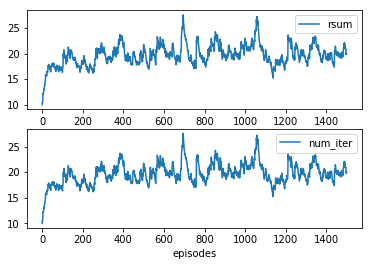

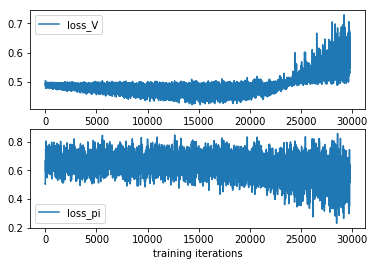

In [36]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
#     print(val_dict[k])
    x, y = zip(*val_dict[k])
    plt.plot(smooth(y, 0.95), label=k)
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
keys = agent.log_dict.keys()
val_dict = agent.log_dict
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()


In [4]:
## batched
gamma = .999

layers_pi = [200, 200]
layers_V  = [200]
lr_pi = 1e-3
lr_V = 1e-3

obs0 = env.reset()
agent = BatchA2CAgent(env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi, lr_V=lr_V,
    gamma=gamma,
    env_methods=env_methods,
    )




out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=1500)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=13	DONE    	rsum=13.0
Episode 2	num_iter=15	DONE    	rsum=15.0
Episode 3	num_iter=15	DONE    	rsum=15.0
Episode 4	num_iter=35	DONE    	rsum=35.0
Episode 5	num_iter=22	DONE    	rsum=22.0
Episode 6	num_iter=30	DONE    	rsum=30.0
Episode 7	num_iter=14	DONE    	rsum=14.0
Episode 8	num_iter=14	DONE    	rsum=14.0
Episode 9	num_iter=16	DONE    	rsum=16.0
Episode 10	num_iter=32	DONE    	rsum=32.0
Episode 11	num_iter=10	DONE    	rsum=10.0
Episode 12	num_iter=18	DONE    	rsum=18.0
Episode 13	num_iter=10	DONE    	rsum=10.0
Episode 14	num_iter=29	DONE    	rsum=29.0
Episode 15	num_iter=17	DONE    	rsum=17.0
Episode 16	num_iter=18	DONE    	rsum=18.0
Episode 17	num_iter=42	DONE    	rsum=42.0
Episode 18	num_iter=12	DONE    	rsum=12.0
Episode 19	num_iter=9	DONE    	rsum=9.0
Episode 20	num_iter=32	DONE    	rsum=32.0
Episode 21	num_iter=12	DONE    	rsum=12.0
Episode 22	num_iter=10	DONE    	rsum=10.0
Episode 23	num_iter=11	DONE    	rsum=11.0
Episode 24	num_iter=19	DONE    	rsum=19.0
Epi

Episode 219	num_iter=10	DONE    	rsum=10.0
Episode 220	num_iter=14	DONE    	rsum=14.0
Episode 221	num_iter=25	DONE    	rsum=25.0
Episode 222	num_iter=15	DONE    	rsum=15.0
Episode 223	num_iter=10	DONE    	rsum=10.0
Episode 224	num_iter=11	DONE    	rsum=11.0
Episode 225	num_iter=12	DONE    	rsum=12.0
Episode 226	num_iter=17	DONE    	rsum=17.0
Episode 227	num_iter=10	DONE    	rsum=10.0
Episode 228	num_iter=14	DONE    	rsum=14.0
Episode 229	num_iter=10	DONE    	rsum=10.0
Episode 230	num_iter=20	DONE    	rsum=20.0
Episode 231	num_iter=11	DONE    	rsum=11.0
Episode 232	num_iter=10	DONE    	rsum=10.0
Episode 233	num_iter=31	DONE    	rsum=31.0
Episode 234	num_iter=13	DONE    	rsum=13.0
Episode 235	num_iter=9	DONE    	rsum=9.0
Episode 236	num_iter=15	DONE    	rsum=15.0
Episode 237	num_iter=9	DONE    	rsum=9.0
Episode 238	num_iter=16	DONE    	rsum=16.0
Episode 239	num_iter=16	DONE    	rsum=16.0
Episode 240	num_iter=8	DONE    	rsum=8.0
Episode 241	num_iter=9	DONE    	rsum=9.0
Episode 242	num_ite

Episode 416	num_iter=83	DONE    	rsum=83.0
Episode 417	num_iter=34	DONE    	rsum=34.0
Episode 418	num_iter=33	DONE    	rsum=33.0
Episode 419	num_iter=14	DONE    	rsum=14.0
Episode 420	num_iter=27	DONE    	rsum=27.0
Episode 421	num_iter=27	DONE    	rsum=27.0
Episode 422	num_iter=24	DONE    	rsum=24.0
Episode 423	num_iter=30	DONE    	rsum=30.0
Episode 424	num_iter=23	DONE    	rsum=23.0
Episode 425	num_iter=16	DONE    	rsum=16.0
Episode 426	num_iter=22	DONE    	rsum=22.0
Episode 427	num_iter=27	DONE    	rsum=27.0
Episode 428	num_iter=42	DONE    	rsum=42.0
Episode 429	num_iter=26	DONE    	rsum=26.0
Episode 430	num_iter=31	DONE    	rsum=31.0
Episode 431	num_iter=68	DONE    	rsum=68.0
Episode 432	num_iter=36	DONE    	rsum=36.0
Episode 433	num_iter=49	DONE    	rsum=49.0
Episode 434	num_iter=18	DONE    	rsum=18.0
Episode 435	num_iter=68	DONE    	rsum=68.0
Episode 436	num_iter=41	DONE    	rsum=41.0
Episode 437	num_iter=54	DONE    	rsum=54.0
Episode 438	num_iter=38	DONE    	rsum=38.0
Episode 439

Episode 610	num_iter=44	DONE    	rsum=44.0
Episode 611	num_iter=56	DONE    	rsum=56.0
Episode 612	num_iter=39	DONE    	rsum=39.0
Episode 613	num_iter=36	DONE    	rsum=36.0
Episode 614	num_iter=29	DONE    	rsum=29.0
Episode 615	num_iter=37	DONE    	rsum=37.0
Episode 616	num_iter=35	DONE    	rsum=35.0
Episode 617	num_iter=56	DONE    	rsum=56.0
Episode 618	num_iter=35	DONE    	rsum=35.0
Episode 619	num_iter=50	DONE    	rsum=50.0
Episode 620	num_iter=61	DONE    	rsum=61.0
Episode 621	num_iter=40	DONE    	rsum=40.0
Episode 622	num_iter=64	DONE    	rsum=64.0
Episode 623	num_iter=59	DONE    	rsum=59.0
Episode 624	num_iter=38	DONE    	rsum=38.0
Episode 625	num_iter=57	DONE    	rsum=57.0
Episode 626	num_iter=43	DONE    	rsum=43.0
Episode 627	num_iter=34	DONE    	rsum=34.0
Episode 628	num_iter=52	DONE    	rsum=52.0
Episode 629	num_iter=33	DONE    	rsum=33.0
Episode 630	num_iter=35	DONE    	rsum=35.0
Episode 631	num_iter=64	DONE    	rsum=64.0
Episode 632	num_iter=58	DONE    	rsum=58.0
Episode 633

Episode 803	num_iter=162	DONE    	rsum=162.0
Episode 804	num_iter=114	DONE    	rsum=114.0
Episode 805	num_iter=142	DONE    	rsum=142.0
Episode 806	num_iter=82	DONE    	rsum=82.0
Episode 807	num_iter=168	DONE    	rsum=168.0
Episode 808	num_iter=150	DONE    	rsum=150.0
Episode 809	num_iter=122	DONE    	rsum=122.0
Episode 810	num_iter=107	DONE    	rsum=107.0
Episode 811	num_iter=115	DONE    	rsum=115.0
Episode 812	num_iter=432	DONE    	rsum=432.0
Episode 813	num_iter=54	DONE    	rsum=54.0
Episode 814	num_iter=67	DONE    	rsum=67.0
Episode 815	num_iter=78	DONE    	rsum=78.0
Episode 816	num_iter=68	DONE    	rsum=68.0
Episode 817	num_iter=85	DONE    	rsum=85.0
Episode 818	num_iter=87	DONE    	rsum=87.0
Episode 819	num_iter=133	DONE    	rsum=133.0
Episode 820	num_iter=99	DONE    	rsum=99.0
Episode 821	num_iter=207	DONE    	rsum=207.0
Episode 822	num_iter=83	DONE    	rsum=83.0
Episode 823	num_iter=95	DONE    	rsum=95.0
Episode 824	num_iter=197	DONE    	rsum=197.0
Episode 825	num_iter=103	DONE 

Episode 989	num_iter=131	DONE    	rsum=131.0
Episode 990	num_iter=128	DONE    	rsum=128.0
Episode 991	num_iter=116	DONE    	rsum=116.0
Episode 992	num_iter=120	DONE    	rsum=120.0
Episode 993	num_iter=144	DONE    	rsum=144.0
Episode 994	num_iter=119	DONE    	rsum=119.0
Episode 995	num_iter=129	DONE    	rsum=129.0
Episode 996	num_iter=140	DONE    	rsum=140.0
Episode 997	num_iter=164	DONE    	rsum=164.0
Episode 998	num_iter=135	DONE    	rsum=135.0
Episode 999	num_iter=141	DONE    	rsum=141.0
Episode 1000	num_iter=112	DONE    	rsum=112.0
Episode 1001	num_iter=149	DONE    	rsum=149.0
Episode 1002	num_iter=127	DONE    	rsum=127.0
Episode 1003	num_iter=163	DONE    	rsum=163.0
Episode 1004	num_iter=146	DONE    	rsum=146.0
Episode 1005	num_iter=100	DONE    	rsum=100.0
Episode 1006	num_iter=117	DONE    	rsum=117.0
Episode 1007	num_iter=116	DONE    	rsum=116.0
Episode 1008	num_iter=117	DONE    	rsum=117.0
Episode 1009	num_iter=142	DONE    	rsum=142.0
Episode 1010	num_iter=112	DONE    	rsum=112.0

Episode 1170	num_iter=455	DONE    	rsum=455.0
Episode 1171	num_iter=361	DONE    	rsum=361.0
Episode 1172	num_iter=500	MAX_ITER	rsum=500.0
Episode 1173	num_iter=433	DONE    	rsum=433.0
Episode 1174	num_iter=390	DONE    	rsum=390.0
Episode 1175	num_iter=500	MAX_ITER	rsum=500.0
Episode 1176	num_iter=235	DONE    	rsum=235.0
Episode 1177	num_iter=478	DONE    	rsum=478.0
Episode 1178	num_iter=500	MAX_ITER	rsum=500.0
Episode 1179	num_iter=420	DONE    	rsum=420.0
Episode 1180	num_iter=500	MAX_ITER	rsum=500.0
Episode 1181	num_iter=500	MAX_ITER	rsum=500.0
Episode 1182	num_iter=500	MAX_ITER	rsum=500.0
Episode 1183	num_iter=500	MAX_ITER	rsum=500.0
Episode 1184	num_iter=257	DONE    	rsum=257.0
Episode 1185	num_iter=500	MAX_ITER	rsum=500.0
Episode 1186	num_iter=261	DONE    	rsum=261.0
Episode 1187	num_iter=500	MAX_ITER	rsum=500.0
Episode 1188	num_iter=157	DONE    	rsum=157.0
Episode 1189	num_iter=500	MAX_ITER	rsum=500.0
Episode 1190	num_iter=328	DONE    	rsum=328.0
Episode 1191	num_iter=500	MAX_ITER

Episode 1350	num_iter=205	DONE    	rsum=205.0
Episode 1351	num_iter=119	DONE    	rsum=119.0
Episode 1352	num_iter=130	DONE    	rsum=130.0
Episode 1353	num_iter=112	DONE    	rsum=112.0
Episode 1354	num_iter=161	DONE    	rsum=161.0
Episode 1355	num_iter=136	DONE    	rsum=136.0
Episode 1356	num_iter=117	DONE    	rsum=117.0
Episode 1357	num_iter=166	DONE    	rsum=166.0
Episode 1358	num_iter=111	DONE    	rsum=111.0
Episode 1359	num_iter=190	DONE    	rsum=190.0
Episode 1360	num_iter=151	DONE    	rsum=151.0
Episode 1361	num_iter=98	DONE    	rsum=98.0
Episode 1362	num_iter=121	DONE    	rsum=121.0
Episode 1363	num_iter=138	DONE    	rsum=138.0
Episode 1364	num_iter=129	DONE    	rsum=129.0
Episode 1365	num_iter=108	DONE    	rsum=108.0
Episode 1366	num_iter=103	DONE    	rsum=103.0
Episode 1367	num_iter=106	DONE    	rsum=106.0
Episode 1368	num_iter=124	DONE    	rsum=124.0
Episode 1369	num_iter=120	DONE    	rsum=120.0
Episode 1370	num_iter=106	DONE    	rsum=106.0
Episode 1371	num_iter=155	DONE    	r

(500.0, 500, True)

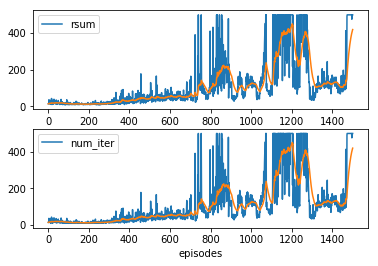

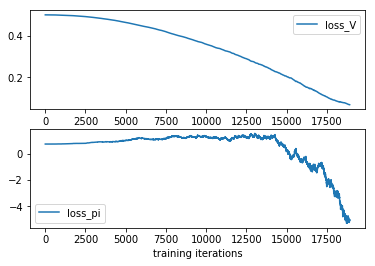

In [7]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.95))
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.999), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()



## GridWorld

In [9]:
env_methods = GridWorldFeaturesMethods()
env = gym.make(env_methods.get_env_name())

plan_num = 1
plan_rewards = {0:-0.001, 3:1, 4:1, 5:-1, 6:-1}
env.setPlan("gridworldPlans/plan{}.txt".format(plan_num), plan_rewards)


env_name = 'gridworld-v0'
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 4 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n']


In [10]:
## batched
gamma = .9

layers_pi = [200, 200]
layers_V  = [200, 200]
lr_pi = 1e-3
lr_V = 1e-3


obs0 = env.reset()
agent = BatchA2CAgent(
    action_space=env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi, lr_V=lr_V,
    gamma=gamma,
    env_methods=env_methods,
    )


out = train_agent(agent, env, max_iter=20, verbose=1, num_episodes=3000)
# play_one_run(agent, env, verbose=2)


Episode 1	num_iter=20	MAX_ITER	rsum=-1.019
Episode 2	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 3	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 4	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 5	num_iter=2	DONE    	rsum=-1.001
Episode 6	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 7	num_iter=4	DONE    	rsum=-1.003
Episode 8	num_iter=1	DONE    	rsum=-1
Episode 9	num_iter=1	DONE    	rsum=-1
Episode 10	num_iter=1	DONE    	rsum=-1
Episode 11	num_iter=6	DONE    	rsum=-1.005
Episode 12	num_iter=1	DONE    	rsum=-1
Episode 13	num_iter=2	DONE    	rsum=-1.001
Episode 14	num_iter=2	DONE    	rsum=-1.001
Episode 15	num_iter=2	DONE    	rsum=-1.001
Episode 16	num_iter=2	DONE    	rsum=-1.001
Episode 17	num_iter=3	DONE    	rsum=-1.002
Episode 18	num_iter=1	DONE    	rsum=-1
Episode 19	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 20	num_iter=20	MAX_ITER	rsum=-1.019
Episode 21	num_iter=3	DONE    	rsum=-1.002
Episode 22	num_iter=9	DONE    	rsum=-0.00700000

Episode 177	num_iter=12	DONE    	rsum=-1.011
Episode 178	num_iter=1	DONE    	rsum=-1
Episode 179	num_iter=3	DONE    	rsum=-1.002
Episode 180	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 181	num_iter=6	DONE    	rsum=-1.005
Episode 182	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 183	num_iter=3	DONE    	rsum=-1.002
Episode 184	num_iter=1	DONE    	rsum=-1
Episode 185	num_iter=6	DONE    	rsum=-1.005
Episode 186	num_iter=6	DONE    	rsum=1.996
Episode 187	num_iter=17	DONE    	rsum=1.9849999999999999
Episode 188	num_iter=12	DONE    	rsum=-1.011
Episode 189	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 190	num_iter=6	DONE    	rsum=-1.005
Episode 191	num_iter=3	DONE    	rsum=-1.002
Episode 192	num_iter=20	MAX_ITER	rsum=0.981
Episode 193	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 194	num_iter=4	DONE    	rsum=-1.003
Episode 195	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 196	num_iter=1	DONE    	rsum=-1
Episode 197	num_iter=5	DONE    	rsum=-1.0

Episode 354	num_iter=20	MAX_ITER	rsum=0.981
Episode 355	num_iter=2	DONE    	rsum=-1.001
Episode 356	num_iter=12	DONE    	rsum=0.989
Episode 357	num_iter=5	DONE    	rsum=-1.004
Episode 358	num_iter=1	DONE    	rsum=-1
Episode 359	num_iter=1	DONE    	rsum=-1
Episode 360	num_iter=10	DONE    	rsum=-1.009
Episode 361	num_iter=13	DONE    	rsum=-0.01100000000000001
Episode 362	num_iter=20	MAX_ITER	rsum=0.981
Episode 363	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 364	num_iter=3	DONE    	rsum=-1.002
Episode 365	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 366	num_iter=13	DONE    	rsum=-1.012
Episode 367	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 368	num_iter=20	MAX_ITER	rsum=-1.019
Episode 369	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 370	num_iter=4	DONE    	rsum=-1.003
Episode 371	num_iter=4	DONE    	rsum=-1.003
Episode 372	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 373	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 374	num_i

Episode 532	num_iter=3	DONE    	rsum=-1.002
Episode 533	num_iter=5	DONE    	rsum=-1.004
Episode 534	num_iter=12	DONE    	rsum=1.99
Episode 535	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 536	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 537	num_iter=1	DONE    	rsum=-1
Episode 538	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 539	num_iter=1	DONE    	rsum=-1
Episode 540	num_iter=7	DONE    	rsum=-1.006
Episode 541	num_iter=1	DONE    	rsum=-1
Episode 542	num_iter=1	DONE    	rsum=-1
Episode 543	num_iter=2	DONE    	rsum=-1.001
Episode 544	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 545	num_iter=3	DONE    	rsum=-1.002
Episode 546	num_iter=2	DONE    	rsum=-1.001
Episode 547	num_iter=20	MAX_ITER	rsum=-0.018000000000000016
Episode 548	num_iter=4	DONE    	rsum=-1.003
Episode 549	num_iter=1	DONE    	rsum=-1
Episode 550	num_iter=3	DONE    	rsum=-1.002
Episode 551	num_iter=2	DONE    	rsum=-1.001
Episode 552	num_iter=1	DONE    	rsum=-1
Episode 553	num_iter=2	

Episode 703	num_iter=2	DONE    	rsum=-1.001
Episode 704	num_iter=1	DONE    	rsum=-1
Episode 705	num_iter=4	DONE    	rsum=-1.003
Episode 706	num_iter=2	DONE    	rsum=-1.001
Episode 707	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 708	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 709	num_iter=1	DONE    	rsum=-1
Episode 710	num_iter=7	DONE    	rsum=-1.006
Episode 711	num_iter=3	DONE    	rsum=-1.002
Episode 712	num_iter=20	MAX_ITER	rsum=0.981
Episode 713	num_iter=1	DONE    	rsum=-1
Episode 714	num_iter=1	DONE    	rsum=-1
Episode 715	num_iter=20	MAX_ITER	rsum=0.981
Episode 716	num_iter=18	DONE    	rsum=-0.016000000000000014
Episode 717	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 718	num_iter=3	DONE    	rsum=-1.002
Episode 719	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 720	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 721	num_iter=7	DONE    	rsum=-1.006
Episode 722	num_iter=13	DONE    	rsum=-1.012
Episode 723	num_iter=6	DONE    	rsum=-1.005

Episode 881	num_iter=18	DONE    	rsum=-0.016000000000000014
Episode 882	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 883	num_iter=6	DONE    	rsum=1.996
Episode 884	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 885	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 886	num_iter=3	DONE    	rsum=-1.002
Episode 887	num_iter=20	MAX_ITER	rsum=0.981
Episode 888	num_iter=16	DONE    	rsum=-1.015
Episode 889	num_iter=3	DONE    	rsum=-1.002
Episode 890	num_iter=1	DONE    	rsum=-1
Episode 891	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 892	num_iter=15	DONE    	rsum=1.987
Episode 893	num_iter=4	DONE    	rsum=-1.003
Episode 894	num_iter=20	MAX_ITER	rsum=0.981
Episode 895	num_iter=18	DONE    	rsum=-0.016000000000000014
Episode 896	num_iter=10	DONE    	rsum=-1.009
Episode 897	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 898	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 899	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 900	num_iter=15	DON

Episode 1066	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1067	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 1068	num_iter=20	MAX_ITER	rsum=0.981
Episode 1069	num_iter=3	DONE    	rsum=-1.002
Episode 1070	num_iter=3	DONE    	rsum=-1.002
Episode 1071	num_iter=6	DONE    	rsum=1.996
Episode 1072	num_iter=8	DONE    	rsum=-1.007
Episode 1073	num_iter=1	DONE    	rsum=-1
Episode 1074	num_iter=1	DONE    	rsum=-1
Episode 1075	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 1076	num_iter=1	DONE    	rsum=-1
Episode 1077	num_iter=2	DONE    	rsum=-1.001
Episode 1078	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 1079	num_iter=1	DONE    	rsum=-1
Episode 1080	num_iter=12	DONE    	rsum=-1.011
Episode 1081	num_iter=5	DONE    	rsum=-1.004
Episode 1082	num_iter=1	DONE    	rsum=-1
Episode 1083	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1084	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1085	num_iter=1	DONE    	rsum=-1
Episode 1086	num_iter=3	DONE    	rs

Episode 1242	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1243	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 1244	num_iter=14	DONE    	rsum=0.987
Episode 1245	num_iter=5	DONE    	rsum=-1.004
Episode 1246	num_iter=1	DONE    	rsum=-1
Episode 1247	num_iter=5	DONE    	rsum=-1.004
Episode 1248	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 1249	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 1250	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 1251	num_iter=3	DONE    	rsum=-1.002
Episode 1252	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 1253	num_iter=20	MAX_ITER	rsum=0.981
Episode 1254	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 1255	num_iter=3	DONE    	rsum=-1.002
Episode 1256	num_iter=4	DONE    	rsum=-1.003
Episode 1257	num_iter=20	MAX_ITER	rsum=0.981
Episode 1258	num_iter=5	DONE    	rsum=-1.004
Episode 1259	num_iter=5	DONE    	rsum=-1.004
Episode 1260	num_iter=6	DONE    	rsum=-1.005
Episode 1261	num_iter=5	DONE    	rsum=-1.

Episode 1409	num_iter=2	DONE    	rsum=-1.001
Episode 1410	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1411	num_iter=8	DONE    	rsum=-1.007
Episode 1412	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1413	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1414	num_iter=1	DONE    	rsum=-1
Episode 1415	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 1416	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1417	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 1418	num_iter=1	DONE    	rsum=-1
Episode 1419	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1420	num_iter=11	DONE    	rsum=-1.01
Episode 1421	num_iter=20	MAX_ITER	rsum=0.981
Episode 1422	num_iter=1	DONE    	rsum=-1
Episode 1423	num_iter=4	DONE    	rsum=-1.003
Episode 1424	num_iter=20	MAX_ITER	rsum=0.981
Episode 1425	num_iter=1	DONE    	rsum=-1
Episode 1426	num_iter=8	DONE    	rsum=1.994
Episode 1427	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 1428	num_iter=20	MAX_ITER	rsum=-

Episode 1593	num_iter=20	MAX_ITER	rsum=0.981
Episode 1594	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1595	num_iter=1	DONE    	rsum=-1
Episode 1596	num_iter=1	DONE    	rsum=-1
Episode 1597	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1598	num_iter=20	MAX_ITER	rsum=-1.019
Episode 1599	num_iter=20	MAX_ITER	rsum=0.981
Episode 1600	num_iter=13	DONE    	rsum=-1.012
Episode 1601	num_iter=10	DONE    	rsum=-1.009
Episode 1602	num_iter=6	DONE    	rsum=-1.005
Episode 1603	num_iter=3	DONE    	rsum=-1.002
Episode 1604	num_iter=4	DONE    	rsum=-1.003
Episode 1605	num_iter=20	MAX_ITER	rsum=0.981
Episode 1606	num_iter=4	DONE    	rsum=-1.003
Episode 1607	num_iter=1	DONE    	rsum=-1
Episode 1608	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1609	num_iter=1	DONE    	rsum=-1
Episode 1610	num_iter=6	DONE    	rsum=-1.005
Episode 1611	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1612	num_iter=17	DONE    	rsum=-1.016
Episode 1613	num_iter=1	DONE    	rsum=-1
Episode 161

Episode 1772	num_iter=2	DONE    	rsum=-1.001
Episode 1773	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1774	num_iter=7	DONE    	rsum=-1.006
Episode 1775	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1776	num_iter=1	DONE    	rsum=-1
Episode 1777	num_iter=1	DONE    	rsum=-1
Episode 1778	num_iter=4	DONE    	rsum=-1.003
Episode 1779	num_iter=1	DONE    	rsum=-1
Episode 1780	num_iter=4	DONE    	rsum=-1.003
Episode 1781	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1782	num_iter=1	DONE    	rsum=-1
Episode 1783	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1784	num_iter=3	DONE    	rsum=-1.002
Episode 1785	num_iter=20	MAX_ITER	rsum=0.981
Episode 1786	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1787	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 1788	num_iter=20	MAX_ITER	rsum=0.981
Episode 1789	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 1790	num_iter=5	DONE    	rsum=-1.004
Episode 1791	num_iter=1	DONE    	rsum=-1
Episode 1792	

Episode 1943	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 1944	num_iter=20	MAX_ITER	rsum=-1.019
Episode 1945	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 1946	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1947	num_iter=3	DONE    	rsum=-1.002
Episode 1948	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1949	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1950	num_iter=1	DONE    	rsum=-1
Episode 1951	num_iter=20	MAX_ITER	rsum=0.981
Episode 1952	num_iter=1	DONE    	rsum=-1
Episode 1953	num_iter=20	MAX_ITER	rsum=0.981
Episode 1954	num_iter=13	DONE    	rsum=-1.012
Episode 1955	num_iter=3	DONE    	rsum=-1.002
Episode 1956	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 1957	num_iter=4	DONE    	rsum=-1.003
Episode 1958	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 1959	num_iter=3	DONE    	rsum=-1.002
Episode 1960	num_iter=2	DONE    	rsum=-1.001
Episode 1961	num_iter=14	DONE    	rsum=-1.013
Episode 1962	num_iter=20	MAX_ITER	rsum=-0.0

Episode 2116	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2117	num_iter=12	DONE    	rsum=-1.011
Episode 2118	num_iter=2	DONE    	rsum=-1.001
Episode 2119	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2120	num_iter=5	DONE    	rsum=-1.004
Episode 2121	num_iter=20	MAX_ITER	rsum=0.981
Episode 2122	num_iter=3	DONE    	rsum=-1.002
Episode 2123	num_iter=12	DONE    	rsum=-1.011
Episode 2124	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2125	num_iter=20	MAX_ITER	rsum=0.981
Episode 2126	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 2127	num_iter=3	DONE    	rsum=-1.002
Episode 2128	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2129	num_iter=5	DONE    	rsum=-1.004
Episode 2130	num_iter=20	MAX_ITER	rsum=1.982
Episode 2131	num_iter=1	DONE    	rsum=-1
Episode 2132	num_iter=2	DONE    	rsum=-1.001
Episode 2133	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 2134	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2135	num_iter=12	DONE    	rsum=-0

Episode 2285	num_iter=20	MAX_ITER	rsum=0.981
Episode 2286	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 2287	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 2288	num_iter=1	DONE    	rsum=-1
Episode 2289	num_iter=5	DONE    	rsum=-1.004
Episode 2290	num_iter=1	DONE    	rsum=-1
Episode 2291	num_iter=3	DONE    	rsum=-1.002
Episode 2292	num_iter=4	DONE    	rsum=-1.003
Episode 2293	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2294	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2295	num_iter=12	DONE    	rsum=-1.011
Episode 2296	num_iter=9	DONE    	rsum=-1.008
Episode 2297	num_iter=7	DONE    	rsum=-1.006
Episode 2298	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2299	num_iter=5	DONE    	rsum=-1.004
Episode 2300	num_iter=1	DONE    	rsum=-1
Episode 2301	num_iter=1	DONE    	rsum=-1
Episode 2302	num_iter=13	DONE    	rsum=-1.012
Episode 2303	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 2304	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode

Episode 2452	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2453	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2454	num_iter=2	DONE    	rsum=-1.001
Episode 2455	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2456	num_iter=14	DONE    	rsum=-1.013
Episode 2457	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 2458	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2459	num_iter=20	MAX_ITER	rsum=0.981
Episode 2460	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 2461	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2462	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2463	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2464	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 2465	num_iter=3	DONE    	rsum=-1.002
Episode 2466	num_iter=20	MAX_ITER	rsum=0.981
Episode 2467	num_iter=12	DONE    	rsum=-1.011
Episode 2468	num_iter=20	MAX_ITER	rsum=0.981
Episode 2469	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 2470	num_it

Episode 2607	num_iter=2	DONE    	rsum=-1.001
Episode 2608	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2609	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 2610	num_iter=20	MAX_ITER	rsum=0.981
Episode 2611	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2612	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 2613	num_iter=2	DONE    	rsum=-1.001
Episode 2614	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2615	num_iter=17	DONE    	rsum=-1.016
Episode 2616	num_iter=20	MAX_ITER	rsum=-1.019
Episode 2617	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2618	num_iter=20	MAX_ITER	rsum=0.981
Episode 2619	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2620	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2621	num_iter=1	DONE    	rsum=-1
Episode 2622	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2623	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2624	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2625	num_iter=11	

Episode 2771	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2772	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2773	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2774	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 2775	num_iter=7	DONE    	rsum=-1.006
Episode 2776	num_iter=1	DONE    	rsum=-1
Episode 2777	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2778	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2779	num_iter=4	DONE    	rsum=-1.003
Episode 2780	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2781	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2782	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2783	num_iter=2	DONE    	rsum=-1.001
Episode 2784	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2785	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2786	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2787	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2788	num_iter=20	MAX_ITER	rsum=-0.0

Episode 2934	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2935	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2936	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 2937	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2938	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2939	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2940	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2941	num_iter=12	DONE    	rsum=-1.011
Episode 2942	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2943	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2944	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2945	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2946	num_iter=2	DONE    	rsum=-1.001
Episode 2947	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2948	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 2949	num_iter=20	MAX_ITER	rsum=0.981
Episode 2950	num_iter=8	DONE    	rsum=-1.007
Episode 2951	num_iter=20	MAX_ITER	rsum

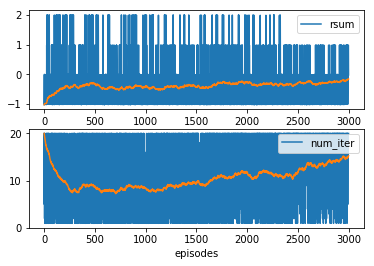

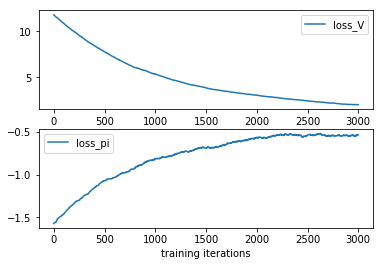

In [11]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.99))
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.999), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()



## LunarLander

In [12]:
env_methods = LunarLanderDiscreteMethods()
env = gym.make(env_methods.get_env_name())


env_name = 'LunarLander-v2'


In [13]:
## batched
gamma = .999

layers_pi = [200, 200]
layers_V  = [200]
lr_pi = 1e-4
lr_V = 1e-3


obs0 = env.reset()
agent = BatchA2CAgent(
    action_space=env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi, lr_V=lr_V,
    gamma=gamma,
    env_methods=env_methods,
    )


out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=3000)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=106	DONE    	rsum=-372.4683153543275
Episode 2	num_iter=96	DONE    	rsum=-114.89091720442966
Episode 3	num_iter=114	DONE    	rsum=-123.46317935206383
Episode 4	num_iter=105	DONE    	rsum=-242.50995881504016
Episode 5	num_iter=105	DONE    	rsum=-397.13579923671534
Episode 6	num_iter=112	DONE    	rsum=-274.5058608370248
Episode 7	num_iter=79	DONE    	rsum=-173.57671365143585
Episode 8	num_iter=60	DONE    	rsum=-78.00062269570984
Episode 9	num_iter=65	DONE    	rsum=-76.76699766349918
Episode 10	num_iter=86	DONE    	rsum=-106.86796011348818
Episode 11	num_iter=107	DONE    	rsum=-136.65496113922669
Episode 12	num_iter=91	DONE    	rsum=-375.8060894809513
Episode 13	num_iter=111	DONE    	rsum=-409.2614681034945
Episode 14	num_iter=101	DONE    	rsum=-296.2565183300169
Episode 15	num_iter=68	DONE    	rsum=-123.07021770883173
Episode 16	num_iter=96	DONE    	rsum=-383.2757491476566
Episode 17	num_iter=80	DONE    	rsum=-336.7129708295814
Episode 18	num_iter=120	DONE    	rsum=-18

Episode 146	num_iter=90	DONE    	rsum=-319.76596952616273
Episode 147	num_iter=98	DONE    	rsum=-187.65134636092137
Episode 148	num_iter=97	DONE    	rsum=-386.81168640341343
Episode 149	num_iter=63	DONE    	rsum=-234.24118398573182
Episode 150	num_iter=108	DONE    	rsum=-329.30984252442875
Episode 151	num_iter=154	DONE    	rsum=-316.30664999518604
Episode 152	num_iter=91	DONE    	rsum=-202.54880466470104
Episode 153	num_iter=97	DONE    	rsum=-97.1348574358883
Episode 154	num_iter=102	DONE    	rsum=-146.52136578393242
Episode 155	num_iter=125	DONE    	rsum=-374.1166027610593
Episode 156	num_iter=108	DONE    	rsum=-376.52227357191055
Episode 157	num_iter=103	DONE    	rsum=-111.31084651695159
Episode 158	num_iter=91	DONE    	rsum=-413.3022362911635
Episode 159	num_iter=89	DONE    	rsum=-92.62597504395485
Episode 160	num_iter=122	DONE    	rsum=-380.67814332121907
Episode 161	num_iter=144	DONE    	rsum=-295.5276941037796
Episode 162	num_iter=113	DONE    	rsum=-401.53962423729007
Episode 163

Episode 287	num_iter=371	DONE    	rsum=-303.89210704697814
Episode 288	num_iter=114	DONE    	rsum=-226.560318447665
Episode 289	num_iter=229	DONE    	rsum=-174.1603391721202
Episode 290	num_iter=193	DONE    	rsum=-326.8115656492312
Episode 291	num_iter=278	DONE    	rsum=-335.40759085306684
Episode 292	num_iter=189	DONE    	rsum=-255.0591378701494
Episode 293	num_iter=130	DONE    	rsum=-150.51462086098277
Episode 294	num_iter=149	DONE    	rsum=-57.7052812545121
Episode 295	num_iter=182	DONE    	rsum=-139.65841090252115
Episode 296	num_iter=369	DONE    	rsum=-219.2710882512326
Episode 297	num_iter=269	DONE    	rsum=-473.6195031564977
Episode 298	num_iter=227	DONE    	rsum=-152.77149873180298
Episode 299	num_iter=174	DONE    	rsum=-216.00318433411002
Episode 300	num_iter=171	DONE    	rsum=-280.51265643040165
Episode 301	num_iter=185	DONE    	rsum=-245.31047959090947
Episode 302	num_iter=140	DONE    	rsum=-153.15085658923874
Episode 303	num_iter=145	DONE    	rsum=-119.23078908508569
Episod

Episode 428	num_iter=261	DONE    	rsum=-141.48925530464598
Episode 429	num_iter=298	DONE    	rsum=-239.96013579037512
Episode 430	num_iter=310	DONE    	rsum=-195.08177311354862
Episode 431	num_iter=342	DONE    	rsum=-84.80266041951774
Episode 432	num_iter=261	DONE    	rsum=-212.10649145336635
Episode 433	num_iter=380	DONE    	rsum=-227.54959557169462
Episode 434	num_iter=310	DONE    	rsum=-200.60501104592532
Episode 435	num_iter=260	DONE    	rsum=-183.83439487972663
Episode 436	num_iter=281	DONE    	rsum=-211.7641335248568
Episode 437	num_iter=500	MAX_ITER	rsum=-216.88548920476669
Episode 438	num_iter=500	MAX_ITER	rsum=-161.04408916074158
Episode 439	num_iter=254	DONE    	rsum=-120.94990295628243
Episode 440	num_iter=353	DONE    	rsum=-253.48262881487187
Episode 441	num_iter=404	DONE    	rsum=-204.12767358010228
Episode 442	num_iter=295	DONE    	rsum=-105.84204645268224
Episode 443	num_iter=233	DONE    	rsum=-138.75155389616626
Episode 444	num_iter=245	DONE    	rsum=-254.56028230585054

Episode 569	num_iter=500	MAX_ITER	rsum=35.600850531940374
Episode 570	num_iter=500	MAX_ITER	rsum=15.342790231806934
Episode 571	num_iter=463	DONE    	rsum=165.11931120141375
Episode 572	num_iter=285	DONE    	rsum=-240.27844262259327
Episode 573	num_iter=371	DONE    	rsum=-223.20957240190592
Episode 574	num_iter=276	DONE    	rsum=-208.7320761096368
Episode 575	num_iter=373	DONE    	rsum=-318.273752140321
Episode 576	num_iter=181	DONE    	rsum=-216.24356121271018
Episode 577	num_iter=256	DONE    	rsum=-46.995465000069714
Episode 578	num_iter=500	MAX_ITER	rsum=52.59948416588186
Episode 579	num_iter=355	DONE    	rsum=-260.8244560098407
Episode 580	num_iter=396	DONE    	rsum=-253.2930847940299
Episode 581	num_iter=203	DONE    	rsum=-48.25815399929155
Episode 582	num_iter=264	DONE    	rsum=-253.48371783719202
Episode 583	num_iter=500	MAX_ITER	rsum=20.73829354844741
Episode 584	num_iter=281	DONE    	rsum=-240.59593691169889
Episode 585	num_iter=263	DONE    	rsum=-14.446172547789502
Episode 58

Episode 710	num_iter=384	DONE    	rsum=-221.30853663662594
Episode 711	num_iter=323	DONE    	rsum=-247.33228319405868
Episode 712	num_iter=311	DONE    	rsum=-75.33108934496607
Episode 713	num_iter=297	DONE    	rsum=-209.36663728898998
Episode 714	num_iter=304	DONE    	rsum=-209.9139299908653
Episode 715	num_iter=179	DONE    	rsum=-62.12862338753152
Episode 716	num_iter=500	MAX_ITER	rsum=30.345258744336398
Episode 717	num_iter=209	DONE    	rsum=-165.87534436921987
Episode 718	num_iter=375	DONE    	rsum=-202.40133828068912
Episode 719	num_iter=500	MAX_ITER	rsum=-25.33922426283842
Episode 720	num_iter=383	DONE    	rsum=-266.4106203109636
Episode 721	num_iter=281	DONE    	rsum=-173.92223476344537
Episode 722	num_iter=305	DONE    	rsum=-168.5902460912755
Episode 723	num_iter=334	DONE    	rsum=-53.4998365222198
Episode 724	num_iter=242	DONE    	rsum=-145.3479687596441
Episode 725	num_iter=242	DONE    	rsum=-124.30939161480728
Episode 726	num_iter=497	DONE    	rsum=-79.48640630618567
Episode 

Episode 851	num_iter=306	DONE    	rsum=-61.00004170121629
Episode 852	num_iter=310	DONE    	rsum=-188.8934792482272
Episode 853	num_iter=500	MAX_ITER	rsum=126.81794540952997
Episode 854	num_iter=451	DONE    	rsum=-253.02251300255483
Episode 855	num_iter=360	DONE    	rsum=-197.5243808336952
Episode 856	num_iter=239	DONE    	rsum=-35.774973568475815
Episode 857	num_iter=500	MAX_ITER	rsum=18.005887219708672
Episode 858	num_iter=340	DONE    	rsum=-328.37267790658353
Episode 859	num_iter=454	DONE    	rsum=-81.03416122981503
Episode 860	num_iter=269	DONE    	rsum=29.168816181347978
Episode 861	num_iter=459	DONE    	rsum=-195.28682132290675
Episode 862	num_iter=452	DONE    	rsum=-259.27590279491005
Episode 863	num_iter=305	DONE    	rsum=-210.31674248502526
Episode 864	num_iter=255	DONE    	rsum=-205.75899584268194
Episode 865	num_iter=383	DONE    	rsum=-67.25209850728878
Episode 866	num_iter=277	DONE    	rsum=-207.24731369875872
Episode 867	num_iter=429	DONE    	rsum=-109.80363604713057
Episo

Episode 992	num_iter=344	DONE    	rsum=-53.25366173529278
Episode 993	num_iter=500	MAX_ITER	rsum=48.898481138835265
Episode 994	num_iter=500	MAX_ITER	rsum=2.763189097641021
Episode 995	num_iter=500	MAX_ITER	rsum=-119.50314007183385
Episode 996	num_iter=369	DONE    	rsum=-58.856081976675355
Episode 997	num_iter=416	DONE    	rsum=-108.26554508234344
Episode 998	num_iter=500	MAX_ITER	rsum=-88.2942708841148
Episode 999	num_iter=500	MAX_ITER	rsum=-9.882218424370421
Episode 1000	num_iter=500	MAX_ITER	rsum=-152.69744001059158
Episode 1001	num_iter=318	DONE    	rsum=-64.82671758089847
Episode 1002	num_iter=500	MAX_ITER	rsum=-111.86329703970029
Episode 1003	num_iter=500	MAX_ITER	rsum=-80.12000743726608
Episode 1004	num_iter=500	MAX_ITER	rsum=8.099411415429998
Episode 1005	num_iter=500	MAX_ITER	rsum=41.80284022109366
Episode 1006	num_iter=500	MAX_ITER	rsum=59.95567416622512
Episode 1007	num_iter=500	MAX_ITER	rsum=61.003208862909375
Episode 1008	num_iter=500	MAX_ITER	rsum=-2.9220050878386097
Epis

Episode 1131	num_iter=500	MAX_ITER	rsum=110.61040917946396
Episode 1132	num_iter=500	MAX_ITER	rsum=58.54307847586579
Episode 1133	num_iter=416	DONE    	rsum=-79.12463800090984
Episode 1134	num_iter=500	MAX_ITER	rsum=118.88501493562063
Episode 1135	num_iter=500	MAX_ITER	rsum=81.03516149545852
Episode 1136	num_iter=344	DONE    	rsum=-232.2982935414262
Episode 1137	num_iter=346	DONE    	rsum=-228.93405017258382
Episode 1138	num_iter=495	DONE    	rsum=-242.27825323030535
Episode 1139	num_iter=333	DONE    	rsum=-227.09811819130692
Episode 1140	num_iter=339	DONE    	rsum=-217.23740355787962
Episode 1141	num_iter=500	MAX_ITER	rsum=30.43146173468764
Episode 1142	num_iter=500	MAX_ITER	rsum=19.497749546210713
Episode 1143	num_iter=500	MAX_ITER	rsum=47.547720625140826
Episode 1144	num_iter=322	DONE    	rsum=-197.83172158895366
Episode 1145	num_iter=500	MAX_ITER	rsum=-9.16636678943707
Episode 1146	num_iter=500	MAX_ITER	rsum=51.183283257413365
Episode 1147	num_iter=253	DONE    	rsum=-10.85238466416

Episode 1270	num_iter=378	DONE    	rsum=-226.8379603956827
Episode 1271	num_iter=500	MAX_ITER	rsum=72.70211330026066
Episode 1272	num_iter=500	MAX_ITER	rsum=77.93512949951895
Episode 1273	num_iter=500	MAX_ITER	rsum=-123.27406292889675
Episode 1274	num_iter=367	DONE    	rsum=-211.6475392057677
Episode 1275	num_iter=370	DONE    	rsum=-243.11317064728078
Episode 1276	num_iter=328	DONE    	rsum=-175.97423174586413
Episode 1277	num_iter=403	DONE    	rsum=-245.19327221995678
Episode 1278	num_iter=442	DONE    	rsum=-204.20230818054435
Episode 1279	num_iter=469	DONE    	rsum=-103.66365729511426
Episode 1280	num_iter=500	MAX_ITER	rsum=114.79337849582805
Episode 1281	num_iter=402	DONE    	rsum=-260.8482810936991
Episode 1282	num_iter=342	DONE    	rsum=-69.54523158352684
Episode 1283	num_iter=337	DONE    	rsum=-16.96238573592501
Episode 1284	num_iter=403	DONE    	rsum=-235.60678880589631
Episode 1285	num_iter=500	MAX_ITER	rsum=89.69363773211646
Episode 1286	num_iter=369	DONE    	rsum=-204.4039775

Episode 1409	num_iter=500	MAX_ITER	rsum=45.720615337431774
Episode 1410	num_iter=476	DONE    	rsum=-90.20560160658796
Episode 1411	num_iter=361	DONE    	rsum=-238.17495000738802
Episode 1412	num_iter=500	MAX_ITER	rsum=123.08240083386613
Episode 1413	num_iter=500	MAX_ITER	rsum=-146.74745685124594
Episode 1414	num_iter=294	DONE    	rsum=-173.0364000188459
Episode 1415	num_iter=292	DONE    	rsum=-163.25333914598315
Episode 1416	num_iter=317	DONE    	rsum=-212.23013935412646
Episode 1417	num_iter=500	MAX_ITER	rsum=-127.55955695966728
Episode 1418	num_iter=500	MAX_ITER	rsum=-122.81638813395504
Episode 1419	num_iter=227	DONE    	rsum=3.2738623442543826
Episode 1420	num_iter=228	DONE    	rsum=-173.54510602895078
Episode 1421	num_iter=255	DONE    	rsum=-132.50977142853398
Episode 1422	num_iter=400	DONE    	rsum=-51.165895737717904
Episode 1423	num_iter=287	DONE    	rsum=-221.39352407839658
Episode 1424	num_iter=207	DONE    	rsum=-170.80618509221307
Episode 1425	num_iter=500	MAX_ITER	rsum=46.99

Episode 1548	num_iter=292	DONE    	rsum=-297.4343880513264
Episode 1549	num_iter=381	DONE    	rsum=-57.8832772126144
Episode 1550	num_iter=500	MAX_ITER	rsum=66.1097941700556
Episode 1551	num_iter=244	DONE    	rsum=-175.05738058835692
Episode 1552	num_iter=320	DONE    	rsum=-83.70513461529279
Episode 1553	num_iter=298	DONE    	rsum=-65.84503590287495
Episode 1554	num_iter=500	MAX_ITER	rsum=106.75875486519956
Episode 1555	num_iter=364	DONE    	rsum=-229.0949877715593
Episode 1556	num_iter=333	DONE    	rsum=-26.23697706931756
Episode 1557	num_iter=320	DONE    	rsum=-39.409359646879764
Episode 1558	num_iter=500	MAX_ITER	rsum=5.667664094422361
Episode 1559	num_iter=499	DONE    	rsum=-261.6350400759617
Episode 1560	num_iter=333	DONE    	rsum=-81.17640494683077
Episode 1561	num_iter=440	DONE    	rsum=-225.85477873789137
Episode 1562	num_iter=337	DONE    	rsum=-226.08718747748065
Episode 1563	num_iter=346	DONE    	rsum=-160.78656852359558
Episode 1564	num_iter=500	MAX_ITER	rsum=104.51175643075

Episode 1687	num_iter=500	MAX_ITER	rsum=150.07259363059774
Episode 1688	num_iter=462	DONE    	rsum=-192.92311099265584
Episode 1689	num_iter=500	MAX_ITER	rsum=112.03604220920907
Episode 1690	num_iter=411	DONE    	rsum=-240.27199096826308
Episode 1691	num_iter=367	DONE    	rsum=-182.30447016600232
Episode 1692	num_iter=258	DONE    	rsum=48.608254892987475
Episode 1693	num_iter=416	DONE    	rsum=-24.85742651938665
Episode 1694	num_iter=500	MAX_ITER	rsum=105.85455592443677
Episode 1695	num_iter=316	DONE    	rsum=-15.904120546158907
Episode 1696	num_iter=500	MAX_ITER	rsum=113.43038200034076
Episode 1697	num_iter=424	DONE    	rsum=196.75971981762007
Episode 1698	num_iter=248	DONE    	rsum=-52.21696095124891
Episode 1699	num_iter=319	DONE    	rsum=2.4197130145300747
Episode 1700	num_iter=261	DONE    	rsum=1.7643495472044464
Episode 1701	num_iter=318	DONE    	rsum=-67.87199214300519
Episode 1702	num_iter=500	MAX_ITER	rsum=56.46990286153293
Episode 1703	num_iter=487	DONE    	rsum=-209.10035471

Episode 1826	num_iter=500	MAX_ITER	rsum=-55.86656176750556
Episode 1827	num_iter=500	MAX_ITER	rsum=131.34207563923252
Episode 1828	num_iter=272	DONE    	rsum=-15.732010120292927
Episode 1829	num_iter=251	DONE    	rsum=-12.338820204361141
Episode 1830	num_iter=462	DONE    	rsum=194.36899362336825
Episode 1831	num_iter=397	DONE    	rsum=-231.86305598350938
Episode 1832	num_iter=500	MAX_ITER	rsum=134.0222542490247
Episode 1833	num_iter=245	DONE    	rsum=-219.9672494683993
Episode 1834	num_iter=270	DONE    	rsum=-30.814461609986523
Episode 1835	num_iter=290	DONE    	rsum=-34.86808378807295
Episode 1836	num_iter=500	MAX_ITER	rsum=-13.416115761399418
Episode 1837	num_iter=320	DONE    	rsum=-15.520019659250323
Episode 1838	num_iter=500	MAX_ITER	rsum=13.14360207113841
Episode 1839	num_iter=330	DONE    	rsum=-182.59501492537595
Episode 1840	num_iter=251	DONE    	rsum=-177.50801532697128
Episode 1841	num_iter=463	DONE    	rsum=214.41017575695122
Episode 1842	num_iter=491	DONE    	rsum=186.123176

Episode 1966	num_iter=393	DONE    	rsum=-67.44154903562024
Episode 1967	num_iter=358	DONE    	rsum=-72.25865374143548
Episode 1968	num_iter=361	DONE    	rsum=-67.92887189864629
Episode 1969	num_iter=290	DONE    	rsum=-25.325040545403525
Episode 1970	num_iter=363	DONE    	rsum=-212.16724222085332
Episode 1971	num_iter=328	DONE    	rsum=17.93007304073788
Episode 1972	num_iter=359	DONE    	rsum=-60.29288301513606
Episode 1973	num_iter=370	DONE    	rsum=-229.47632383703223
Episode 1974	num_iter=344	DONE    	rsum=-204.04114917005487
Episode 1975	num_iter=324	DONE    	rsum=-183.9169373741321
Episode 1976	num_iter=330	DONE    	rsum=-229.1272031463842
Episode 1977	num_iter=353	DONE    	rsum=-70.09844777778028
Episode 1978	num_iter=238	DONE    	rsum=-167.47515305093404
Episode 1979	num_iter=381	DONE    	rsum=-61.588991233344125
Episode 1980	num_iter=437	DONE    	rsum=-55.03110207267139
Episode 1981	num_iter=398	DONE    	rsum=-57.355455112309045
Episode 1982	num_iter=293	DONE    	rsum=-177.20628

Episode 2105	num_iter=368	DONE    	rsum=-171.54777556271597
Episode 2106	num_iter=263	DONE    	rsum=-16.192991633008376
Episode 2107	num_iter=500	MAX_ITER	rsum=-59.12694524720502
Episode 2108	num_iter=500	MAX_ITER	rsum=140.87147676686922
Episode 2109	num_iter=500	MAX_ITER	rsum=117.26388641404073
Episode 2110	num_iter=500	MAX_ITER	rsum=104.56837503565056
Episode 2111	num_iter=484	DONE    	rsum=223.5199100427817
Episode 2112	num_iter=286	DONE    	rsum=-191.7028321750064
Episode 2113	num_iter=331	DONE    	rsum=-60.19788595290639
Episode 2114	num_iter=500	MAX_ITER	rsum=143.9067015258853
Episode 2115	num_iter=354	DONE    	rsum=-64.89662730842431
Episode 2116	num_iter=274	DONE    	rsum=-201.08984441990722
Episode 2117	num_iter=240	DONE    	rsum=-3.6902125279137863
Episode 2118	num_iter=327	DONE    	rsum=8.325471615225098
Episode 2119	num_iter=296	DONE    	rsum=-29.441338944288674
Episode 2120	num_iter=500	MAX_ITER	rsum=150.0921179185011
Episode 2121	num_iter=500	MAX_ITER	rsum=155.77522786439

Episode 2244	num_iter=376	DONE    	rsum=-84.91650886984226
Episode 2245	num_iter=311	DONE    	rsum=-174.79817232470901
Episode 2246	num_iter=453	DONE    	rsum=-266.03044356116243
Episode 2247	num_iter=500	MAX_ITER	rsum=53.87687242179529
Episode 2248	num_iter=500	MAX_ITER	rsum=109.35505684717985
Episode 2249	num_iter=326	DONE    	rsum=-157.04185049546047
Episode 2250	num_iter=500	MAX_ITER	rsum=161.92011965240494
Episode 2251	num_iter=366	DONE    	rsum=-217.25887287435125
Episode 2252	num_iter=500	MAX_ITER	rsum=85.66096233615491
Episode 2253	num_iter=359	DONE    	rsum=-88.14672051517235
Episode 2254	num_iter=309	DONE    	rsum=-147.7724668702525
Episode 2255	num_iter=349	DONE    	rsum=-89.69793552594993
Episode 2256	num_iter=500	MAX_ITER	rsum=43.72818791320882
Episode 2257	num_iter=374	DONE    	rsum=-204.8046790913731
Episode 2258	num_iter=244	DONE    	rsum=-11.851780005610522
Episode 2259	num_iter=357	DONE    	rsum=-240.18746341113433
Episode 2260	num_iter=500	MAX_ITER	rsum=94.5666253556

Episode 2383	num_iter=246	DONE    	rsum=-0.4411978534845815
Episode 2384	num_iter=255	DONE    	rsum=48.73405838756787
Episode 2385	num_iter=285	DONE    	rsum=-223.06381765244038
Episode 2386	num_iter=269	DONE    	rsum=26.774347425862473
Episode 2387	num_iter=500	MAX_ITER	rsum=120.15100032665897
Episode 2388	num_iter=304	DONE    	rsum=-205.7094721466756
Episode 2389	num_iter=266	DONE    	rsum=-34.24717394618091
Episode 2390	num_iter=500	MAX_ITER	rsum=97.61117977645533
Episode 2391	num_iter=317	DONE    	rsum=-67.33353282051512
Episode 2392	num_iter=273	DONE    	rsum=-209.28153913988834
Episode 2393	num_iter=500	MAX_ITER	rsum=115.82668089172441
Episode 2394	num_iter=472	DONE    	rsum=-51.16638617139097
Episode 2395	num_iter=500	MAX_ITER	rsum=82.81548874267746
Episode 2396	num_iter=249	DONE    	rsum=-183.5116907974678
Episode 2397	num_iter=341	DONE    	rsum=-219.33911006355981
Episode 2398	num_iter=319	DONE    	rsum=-248.57521621038143
Episode 2399	num_iter=316	DONE    	rsum=-242.979626358

Episode 2522	num_iter=184	DONE    	rsum=-7.16074580697196
Episode 2523	num_iter=303	DONE    	rsum=-33.60589050358172
Episode 2524	num_iter=291	DONE    	rsum=-177.60854707906086
Episode 2525	num_iter=500	MAX_ITER	rsum=112.32886472123106
Episode 2526	num_iter=274	DONE    	rsum=-20.173360833646484
Episode 2527	num_iter=249	DONE    	rsum=-164.82989537329257
Episode 2528	num_iter=299	DONE    	rsum=-61.71507547152285
Episode 2529	num_iter=277	DONE    	rsum=-190.92526932323142
Episode 2530	num_iter=350	DONE    	rsum=-54.836829640746885
Episode 2531	num_iter=229	DONE    	rsum=-169.89826708130659
Episode 2532	num_iter=325	DONE    	rsum=-159.83421807784836
Episode 2533	num_iter=340	DONE    	rsum=207.87510295857942
Episode 2534	num_iter=489	DONE    	rsum=157.20625612335442
Episode 2535	num_iter=309	DONE    	rsum=9.640885466988621
Episode 2536	num_iter=500	MAX_ITER	rsum=144.38561154901487
Episode 2537	num_iter=279	DONE    	rsum=4.5364466085758295
Episode 2538	num_iter=500	MAX_ITER	rsum=91.44796284

Episode 2661	num_iter=500	MAX_ITER	rsum=97.86889014630103
Episode 2662	num_iter=500	MAX_ITER	rsum=145.9354496059529
Episode 2663	num_iter=298	DONE    	rsum=-41.83798181398363
Episode 2664	num_iter=500	MAX_ITER	rsum=146.07743291083668
Episode 2665	num_iter=319	DONE    	rsum=-17.015682534682625
Episode 2666	num_iter=433	DONE    	rsum=177.92419896951418
Episode 2667	num_iter=296	DONE    	rsum=-27.69467954703724
Episode 2668	num_iter=326	DONE    	rsum=-196.2407488110482
Episode 2669	num_iter=290	DONE    	rsum=-181.49511182013168
Episode 2670	num_iter=341	DONE    	rsum=-217.07480754655438
Episode 2671	num_iter=355	DONE    	rsum=3.364449411899159
Episode 2672	num_iter=470	DONE    	rsum=-249.90427869487317
Episode 2673	num_iter=299	DONE    	rsum=-158.91780410040167
Episode 2674	num_iter=298	DONE    	rsum=-197.57360580233325
Episode 2675	num_iter=500	MAX_ITER	rsum=-85.13644763184148
Episode 2676	num_iter=317	DONE    	rsum=-185.07643302286368
Episode 2677	num_iter=277	DONE    	rsum=-184.2395320

Episode 2800	num_iter=245	DONE    	rsum=-9.9537097297721
Episode 2801	num_iter=317	DONE    	rsum=-197.98547371458966
Episode 2802	num_iter=500	MAX_ITER	rsum=91.63374291603071
Episode 2803	num_iter=319	DONE    	rsum=-192.3668286879991
Episode 2804	num_iter=500	MAX_ITER	rsum=45.520845296150746
Episode 2805	num_iter=310	DONE    	rsum=-177.32332574636462
Episode 2806	num_iter=315	DONE    	rsum=-179.3095278390362
Episode 2807	num_iter=452	DONE    	rsum=-233.74374609850776
Episode 2808	num_iter=459	DONE    	rsum=197.50682056514552
Episode 2809	num_iter=500	MAX_ITER	rsum=130.72642077114645
Episode 2810	num_iter=422	DONE    	rsum=-257.6777983444714
Episode 2811	num_iter=500	MAX_ITER	rsum=144.74351821130486
Episode 2812	num_iter=313	DONE    	rsum=-183.6757976185515
Episode 2813	num_iter=500	MAX_ITER	rsum=102.47923903813822
Episode 2814	num_iter=366	DONE    	rsum=-206.4325063785323
Episode 2815	num_iter=282	DONE    	rsum=-202.8517109628009
Episode 2816	num_iter=500	MAX_ITER	rsum=93.8441044681333

Episode 2939	num_iter=500	MAX_ITER	rsum=151.51251042847858
Episode 2940	num_iter=301	DONE    	rsum=-202.55856015689852
Episode 2941	num_iter=321	DONE    	rsum=-180.2499113140525
Episode 2942	num_iter=303	DONE    	rsum=-175.83445037359414
Episode 2943	num_iter=237	DONE    	rsum=-159.08539498076982
Episode 2944	num_iter=332	DONE    	rsum=-97.93391862974175
Episode 2945	num_iter=237	DONE    	rsum=8.915475283061511
Episode 2946	num_iter=307	DONE    	rsum=-71.06052511009888
Episode 2947	num_iter=423	DONE    	rsum=-201.54106926282873
Episode 2948	num_iter=379	DONE    	rsum=-204.02618355992408
Episode 2949	num_iter=366	DONE    	rsum=-211.00474995011416
Episode 2950	num_iter=304	DONE    	rsum=12.332928678765356
Episode 2951	num_iter=303	DONE    	rsum=-67.02195560759608
Episode 2952	num_iter=500	MAX_ITER	rsum=68.80821795563791
Episode 2953	num_iter=500	MAX_ITER	rsum=102.13858990749641
Episode 2954	num_iter=321	DONE    	rsum=-207.66119844154443
Episode 2955	num_iter=252	DONE    	rsum=-27.2684240

(-38.850018101895714, 249, True)

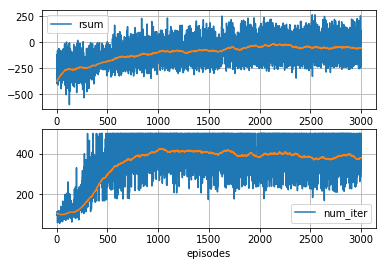

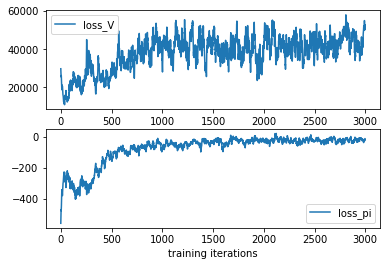

In [14]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.99))
    plt.grid()
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()

